In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import numpy as np
from utils import filt_decompose

In [2]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'


In [3]:
ncfile = '/data/jupyter-ubuntu/TIDE/NRA/NRA_airgap_RAW_2023_60s.nc'
ds = xr.open_dataset(ncfile)
ds

<xarray.Dataset>
Dimensions:  (time: 523799)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01T00:00:00.220000 ... 2023-12-30T...
Data variables:
    airgap   (time) float64 ...

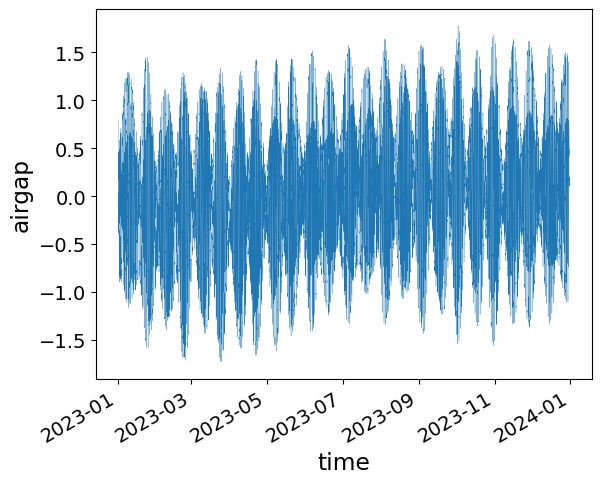

In [4]:
ds['airgap'].plot(lw=0.2)

In [5]:
time = ds.time.values

time_utc = time - np.timedelta64(8*3600, 's')

dt = (time[1:]-time[:-1]).mean()
dtsec = dt.astype(float)*1e-9

# Important ssh = -1*airgap i.e. airgap grows when water level drops
ssh  = -ds['airgap']
ssh['time'] = time_utc
yf = filt_decompose(ssh, dtsec)

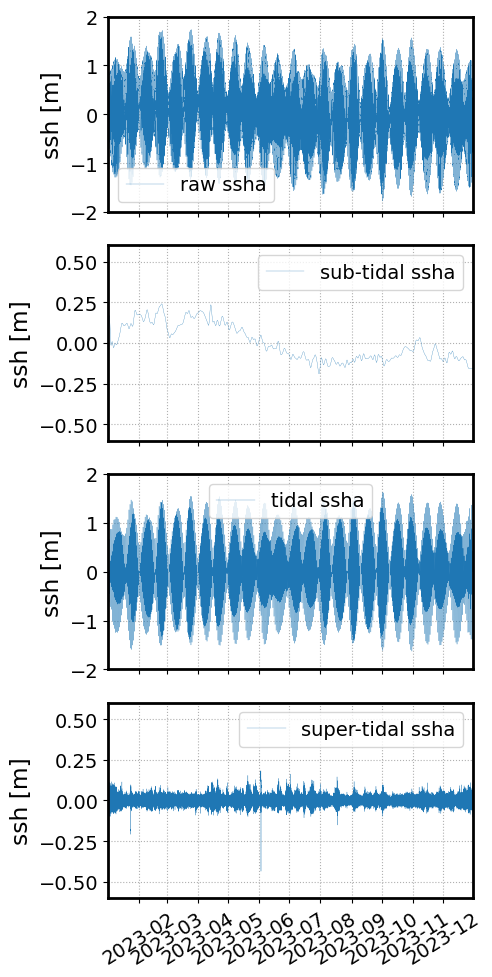

In [109]:
plt.figure(figsize=(5,10))

ax0 = plt.subplot(411)
ssh.plot(lw=0.2, label='raw ssha')
ax0.set_xticklabels([])
plt.xlim(time[0], time[-1])
plt.ylim(-2.,2.)
plt.grid(True, ls=':')
plt.ylabel('ssh [m]')
plt.xlabel('')
plt.legend()

ax1 = plt.subplot(412,)
plt.plot(time, yf[:,0], lw=0.2, label='sub-tidal ssha')
ax1.set_xticklabels([])
plt.xlim(time[0], time[-1])
plt.ylim(-0.6, 0.6)
plt.grid(True, ls=':')
plt.ylabel('ssh [m]')
plt.legend()

ax2 = plt.subplot(413,)
plt.plot(time, yf[:,1], lw=0.2, label='tidal ssha')
ax2.set_xticklabels([])
plt.xlim(time[0], time[-1])
plt.ylim(-2., 2.)
plt.grid(True, ls=':')
plt.ylabel('ssh [m]')
plt.legend()

ax3 = plt.subplot(414, )
plt.plot(time, yf[:,2], lw=0.2, label='super-tidal ssha')
plt.xticks(rotation=32)
plt.xlim(time[0], time[-1])
plt.ylim(-0.6, .6)
plt.grid(True, ls=':')
plt.ylabel('ssh [m]')
plt.legend()

plt.tight_layout()
plt.savefig('../FIGURES/NRA_AirGap_FilteredData.png')

In [6]:
from nwatides import fes, hanalysis

## NRA location

https://apps.sentinel-hub.com/eo-browser/?zoom=18&lat=-19.58356&lng=116.13691&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fservices.sentinel-hub.com%2Fogc%2Fwms%2Fbd86bcc0-f318-402b-a145-015f85b9427e&datasetId=S2L2A&fromTime=2024-03-09T00%3A00%3A00.000Z&toTime=2024-03-09T23%3A59%3A59.999Z&layerId=1_TRUE_COLOR&demSource3D=%22MAPZEN%22

In [7]:
ilon, ilat = np.array([116.1376]), np.array([-19.5842]) # NRA location
constituents, minor = None, None
h= fes.tidal_prediction(ilon, ilat, pd.DatetimeIndex(time_utc), 'z')
h
#fes.load_tidal_amplitudes_np(ilon, ilat, 'z', constituents=None)

not broadcasting because len(lon)==len(lat)


<xarray.Dataset>
Dimensions:  (lon: 1, lat: 1, time: 523799)
Coordinates:
  * lon      (lon) float64 116.1
  * lat      (lat) float64 -19.58
  * time     (time) datetime64[ns] 2022-12-31T16:00:00.220000 ... 2023-12-30T...
Data variables:
    z_tide   (lon, time) float64 -0.4579 -0.4563 -0.4546 ... 1.09 1.092 1.093

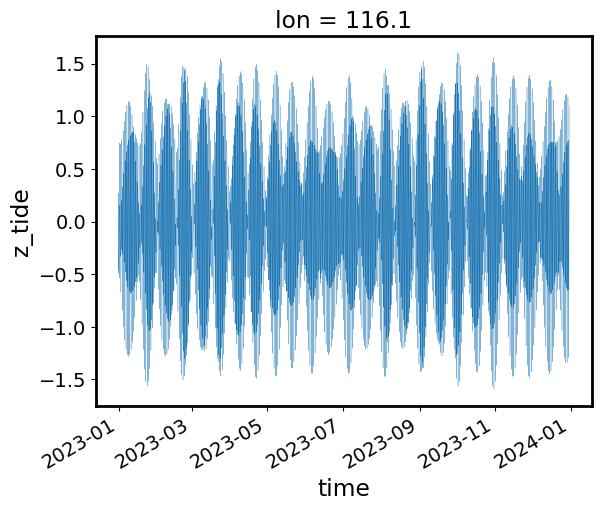

In [82]:
h['z_tide'][0,:].plot(lw=0.2)

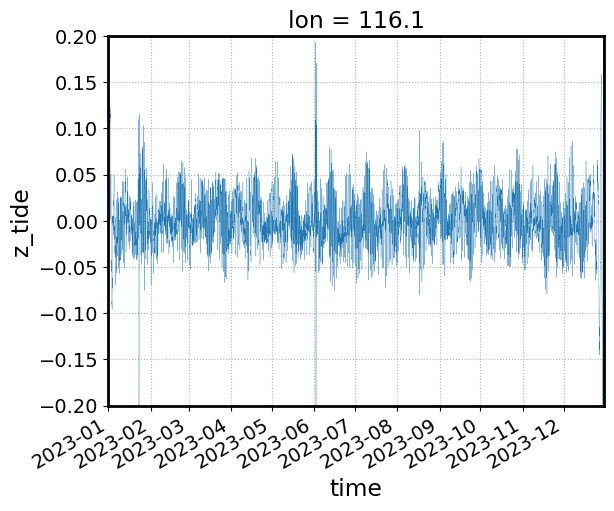

In [83]:
(h['z_tide'][0,:]-yf[:,1]).plot(lw=0.2)
plt.xlim(time_utc[0], time_utc[-1])
plt.ylim(-0.2 ,0.2)
plt.grid(True, ls=':')
# (h['z_tide'][0,:]).plot(lw=0.2)

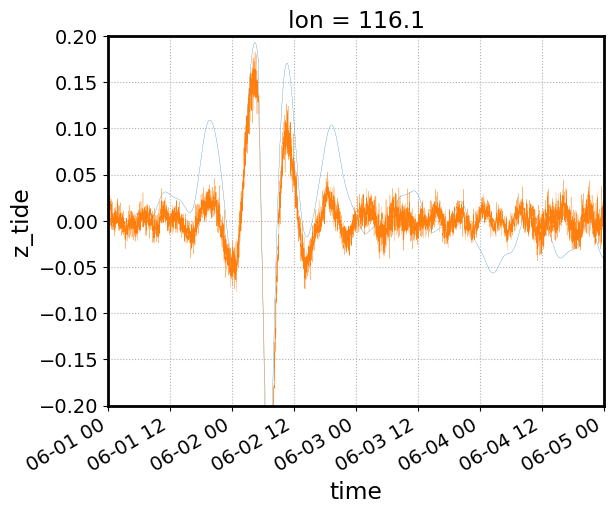

In [84]:
h_fes = h['z_tide'][0,:]
h_residual = h_fes-yf[:,1]
h_residual.plot(lw=0.2)
plt.plot(time_utc, yf[:,2], lw=0.2)
plt.xlim(time_utc[0], time_utc[-1])

plt.xlim(np.datetime64('2023-06-01'), np.datetime64('2023-06-05'))
plt.ylim(-0.2 ,0.2)
plt.grid(True, ls=':')

In [85]:
# Compute the phase-locked component
constituents = fes.default_fes_constituents
h_lsq = hanalysis.least_square(h_residual, time_utc, constituents)
h_phaselocked = h_lsq['h_predicted']
h_nonphaselocked = h_lsq['h_residual']

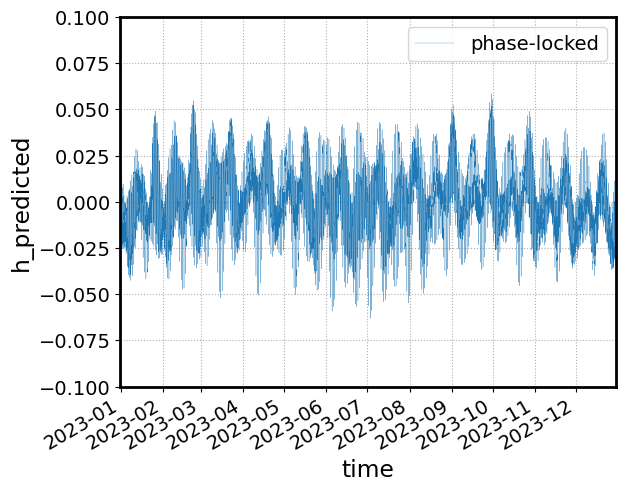

In [86]:
h_phaselocked.plot(lw=0.2, label='phase-locked')
# h_nonphaselocked.plot(lw=0.2)
plt.xlim(time_utc[0], time_utc[-1])
# plt.xlim(np.datetime64('2023-06-01'), np.datetime64('2023-06-30'))
plt.ylim(-0.1 ,0.1)
plt.grid(True, ls=':')
plt.legend()

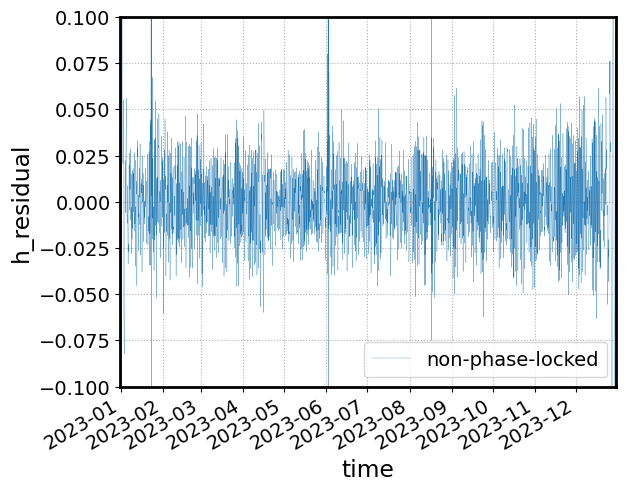

In [87]:
h_nonphaselocked.plot(lw=0.2, label='non-phase-locked')
# h_nonphaselocked.plot(lw=0.2)
plt.xlim(time_utc[0], time_utc[-1])
# plt.xlim(np.datetime64('2023-06-01'), np.datetime64('2023-06-30'))
plt.ylim(-0.1 ,0.1)
plt.grid(True, ls=':')
plt.legend()

In [95]:
# Output dataset
h_phaselocked.name = 'h_phase_locked'
h_nonphaselocked.name = 'h_non_phase_locked'
h_fes.name = 'h_fes2014'
ssh.name = 'ssha'
ds_out = xr.merge([h_phaselocked, h_nonphaselocked, h_fes, ssh])
ds_out

<xarray.Dataset>
Dimensions:             (time: 523799)
Coordinates:
  * time                (time) datetime64[ns] 2022-12-31T16:00:00.220000 ... ...
    lon                 float64 116.1
Data variables:
    h_phase_locked      (time) float64 0.02557 0.02554 ... 0.01383 0.01372
    h_non_phase_locked  (time) float64 -0.2972 -0.2999 -0.3026 ... 1.078 1.08
    h_fes2014           (time) float64 -0.4579 -0.4563 -0.4546 ... 1.092 1.093
    ssha                (time) float64 -0.7873 -0.5752 ... -0.1558 -0.1546

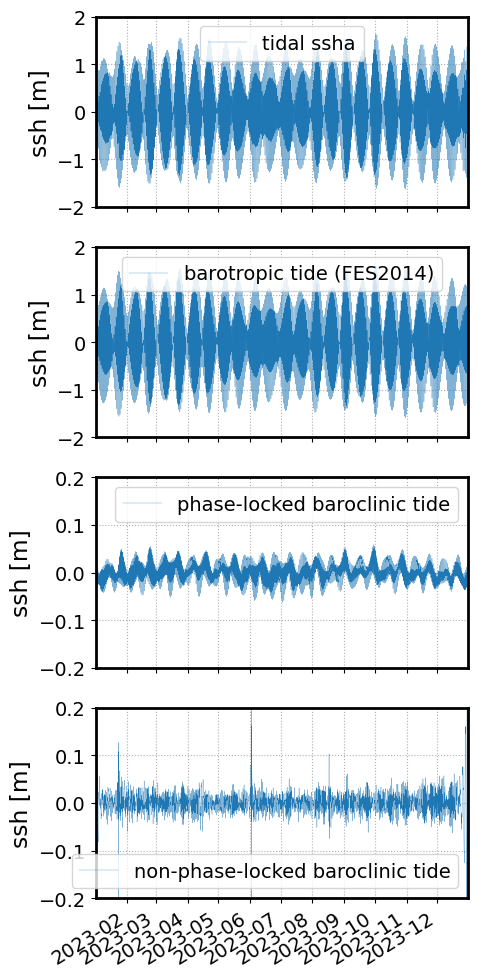

In [108]:
plt.figure(figsize=(5,10))

ax0 = plt.subplot(411)
plt.plot(time, yf[:,1], lw=0.2, label='tidal ssha')
ax0.set_xticklabels([])
plt.xlim(time[0], time[-1])
plt.ylim(-2.,2.)
plt.grid(True, ls=':')
plt.ylabel('ssh [m]')
plt.xlabel('')
plt.legend()

ax1 = plt.subplot(412,)
ds_out['h_fes2014'].plot(lw=0.2, label='barotropic tide (FES2014)')
ax1.set_xticklabels([])
plt.xlim(time[0], time[-1])
plt.ylim(-2,2)
plt.grid(True, ls=':')
plt.ylabel('ssh [m]')
plt.legend()
plt.title('')
plt.xlabel('')

ax2 = plt.subplot(413,)
ds_out['h_phase_locked'].plot(lw=0.2, label='phase-locked baroclinic tide')
ax2.set_xticklabels([])
plt.xlim(time[0], time[-1])
plt.ylim(-0.2, 0.2)
plt.grid(True, ls=':')
plt.ylabel('ssh [m]')
plt.legend()
plt.title('')
plt.xlabel('')

ax3 = plt.subplot(414, )
ds_out['h_non_phase_locked'].plot(lw=0.2, label='non-phase-locked baroclinic tide')
plt.xticks(rotation=32)
plt.xlim(time[0], time[-1])
plt.ylim(-0.2, .2)
plt.grid(True, ls=':')
plt.ylabel('ssh [m]')
plt.legend()
plt.title('')
plt.xlabel('')

plt.tight_layout()
plt.savefig('../FIGURES/NRA_AirGap_TidalAnalysis.png')